# Sleeping pills

A pharma company just designed a new pill to help you sleep. They got data, but it doesn't come from a randomized control trial. They want to know: Does the drug work? Does it help people of different ages equally or differently?

We will make use of the S-learner and the T-learner approaches to estimate the drug's conditional treatment effect (CATE), and try to answer those questions rigorously. The underlying ML model used in both cases will be random forests.

Here's our causal model:
- Treatment (pill): taking or not taking the new med (binary: 0 or 1)
- Outcome (qual): the quality of sleep (continuous)
- Feature/Confounder (age): The age of the subject (discrete)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)

### Define the simulation mechanism

Here we define the age of our subjects, how well people sleep normally (under no medication) as a function of age, and how the pill actually helps them. 

We also define the tendency of people of different ages to take this med, and how noisy our measuring mechanism is when it comes to assessing people's sleep quality.

⚠️ The pill effect varies depending on the person's age, i.e., it has a heterogeneous effect. 

⚠️ The fact that older people are more likely to take the pill makes age a confounder! 

In [2]:
def generate_age(n):
    """Age of the subjects.
    
    Subjects will be uniformily distributed, centered around 18 years of age.
    """
    return np.random.uniform(18, 90, size=n)

def baseline_quality(age):
    """Baseline sleep quality as a function of age.
    
    The sleep quality without any intervention.
    """
    return 4.0 - 0.04 * (age - 40) - 0.4 * np.sin(1e-1*(age - 40))

def true_cate(age):
    """Pill effect as a function of age.
    
    The true (nonlinear) CATE: A bell-shaped function that yields little to no effect 
    until the age of 40. Then a positive effect, peaking at 70. Followed by reducing 
    effectiveness until the age of 90.
    """
    return 1.5 * np.exp(-((age - 70) ** 2) / (2 * 12 ** 2))

def propensity(age):
    """How likely people are to use the pill.

    Older people are more likely to make use of the drug.
    """
    return 0.05 + 0.4 / (1 + np.exp(-(age - 55) / 10.0))

def measurement_noise(n):
    """Measurement noise."""
    return np.random.normal(scale=0.25, size=n)

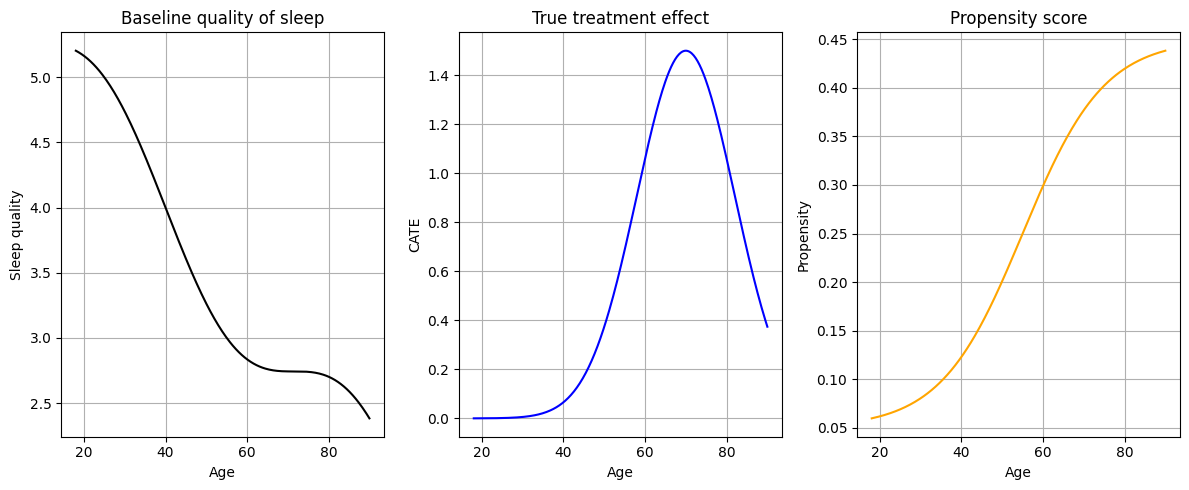

In [3]:
# Visualize the true relationships

ages = np.linspace(18, 90, 300)
baseline = baseline_quality(ages)
true_effects = true_cate(ages)
propensities = propensity(ages)
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(ages, baseline, label="Sleep quality", color="black")
plt.xlabel("Age")
plt.ylabel("Sleep quality")
plt.title("Baseline quality of sleep")
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(ages, true_effects, label="True CATE", color="blue")
plt.xlabel("Age")
plt.ylabel("CATE")
plt.title("True treatment effect")
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(ages, propensities, label="Propensity", color="orange")
plt.xlabel("Age")
plt.ylabel("Propensity")
plt.title("Propensity score")
plt.grid()
plt.tight_layout()

### Generate and explore the data

In [4]:
# Generate data
n = 3000
age = generate_age(n)
true_effect = true_cate(age)
baseline = baseline_quality(age)
epsilon = measurement_noise(n)
p = propensity(age)

T = np.random.binomial(1, p)
Y = baseline + T * true_effect + epsilon

df = pd.DataFrame({"age": age, "T": T, "Y": Y, "true_effect": true_effect, "propensity": p})
df.head()

,age,T,Y,true_effect,propensity
0,68.145781,0,2.774833,1.482200,0.365311
1,38.602032,0,4.087382,0.048920,0.114997
2,34.333305,1,4.760301,0.018105,0.094952
3,57.694663,1,3.766806,0.886651,0.276785
4,69.801766,1,4.303596,1.499795,0.375840


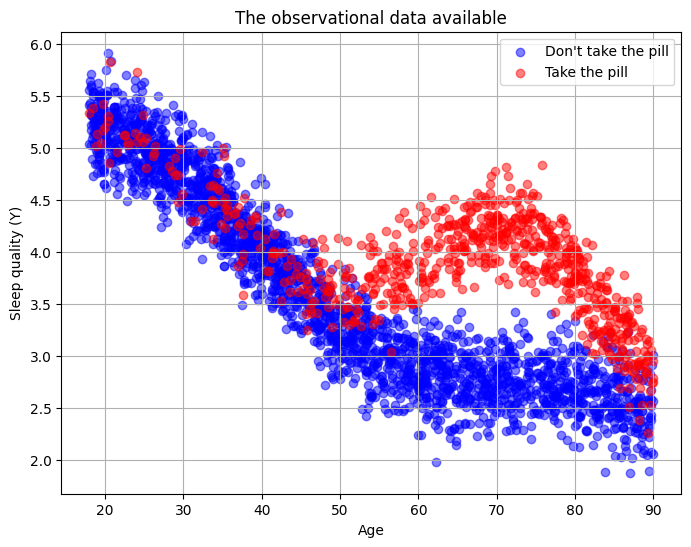

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(
    df.loc[df["T"] == 0, "age"],
    df.loc[df["T"] == 0, "Y"],
    c="blue",
    alpha=0.5,
    label="Don't take the pill",
)
plt.scatter(
    df.loc[df["T"] == 1, "age"],
    df.loc[df["T"] == 1, "Y"],
    c="red",
    alpha=0.5,
    label="Take the pill",
)
plt.legend()
plt.xlabel("Age")
plt.ylabel("Sleep quality (Y)")
plt.title("The observational data available")
plt.grid()

Text(0.5, 1.0, 'Treatment distribution')

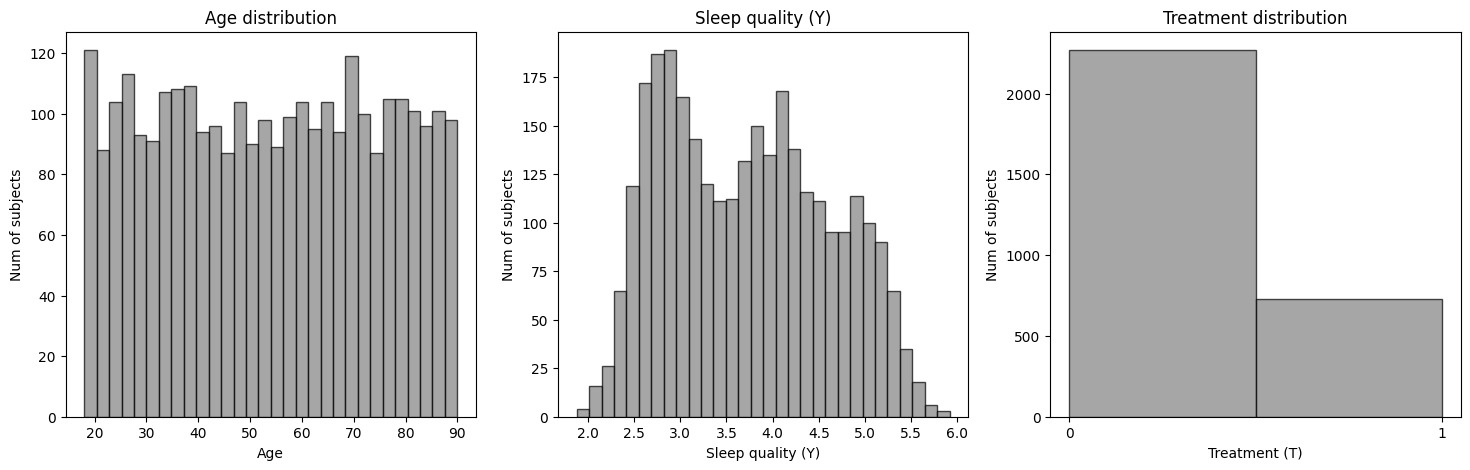

In [6]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.hist(df["age"], bins=30, color="gray", edgecolor="black", alpha=0.7)
plt.xlabel("Age")
plt.ylabel("Num of subjects")
plt.title("Age distribution")
plt.subplot(1, 3, 2)
plt.hist(df["Y"], bins=30, color="gray", edgecolor="black",alpha=0.7)
plt.xlabel("Sleep quality (Y)")
plt.ylabel("Num of subjects")
plt.title("Sleep quality (Y)")
plt.subplot(1, 3, 3)
plt.hist(df["T"], bins=2, color="gray", edgecolor="black",alpha=0.7)
plt.xticks([0, 1])
plt.xlabel("Treatment (T)")
plt.ylabel("Num of subjects")
plt.title("Treatment distribution")

### Train metalearners using random forest models

In [7]:
# 2) Train / test split
train, test = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)
X_train = train[["age"]]
X_test = test[["age"]]
T_train = train["T"].values
T_test = test["T"].values
Y_train = train["Y"].values
Y_test = test["Y"].values

regularization_params = {
    "max_depth": 20, # limit depth to avoid overfitting on small data
    "n_estimators": 500, # number of trees in the forest
    "min_samples_leaf": 20, # minimum samples per leaf to avoid overfitting
}

# %%
# 3) S-learner: single model taking treatment as a feature
s_model = RandomForestRegressor(random_state=RANDOM_STATE, **regularization_params)
# Concatenate age and treatment
s_model.fit(np.column_stack([X_train["age"], T_train]), Y_train)

# For test set, predict outcome under T=1 and T=0
X_test_age = X_test["age"].values
X_test_t1 = np.column_stack([X_test_age, np.ones_like(X_test_age)])
X_test_t0 = np.column_stack([X_test_age, np.zeros_like(X_test_age)])

y_pred_t1_s = s_model.predict(X_test_t1)
y_pred_t0_s = s_model.predict(X_test_t0)

cate_s = y_pred_t1_s - y_pred_t0_s

# %%
# 4) T-learner: two separate models trained on treated and control groups
# Model for treated
model_treated = RandomForestRegressor(random_state=RANDOM_STATE, **regularization_params)
model_control = RandomForestRegressor(random_state=RANDOM_STATE, **regularization_params)

train_treated = train[train["T"] == 1]
train_control = train[train["T"] == 0]

# If one group becomes extremely small, regularization or other methods would be needed.
model_treated.fit(train_treated[["age"]], train_treated["Y"])
model_control.fit(train_control[["age"]], train_control["Y"])

# Predict potential outcomes on test set
y_pred1_t = model_treated.predict(X_test)
y_pred0_t = model_control.predict(X_test)
cate_t = y_pred1_t - y_pred0_t

### Evaluate the two approaches based on different metrics

Assess the prediction error on the test set, the predicted ATE, and the functional outputs (the CATE function).

PEHE (S-learner): 0.0731
PEHE (T-learner): 0.1145
ATE true: 0.5793, S: 0.5468, T: 0.5567


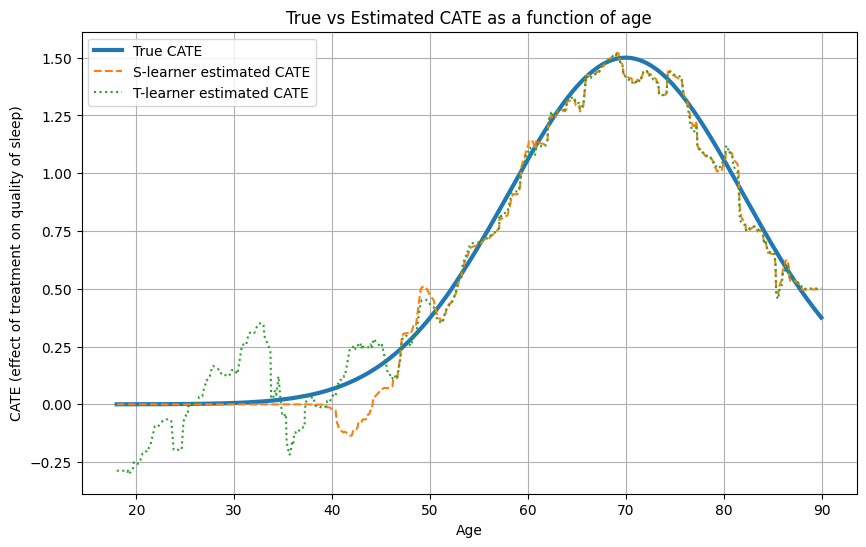

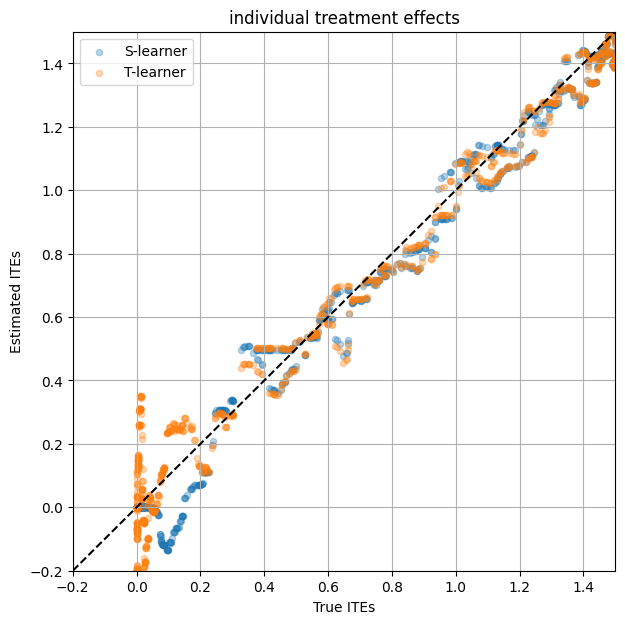

In [ ]:
# 5) Evaluation: compare estimated CATE to true CATE on test set
true_cate_test = test["true_effect"].values

pehe_s = np.sqrt(mean_squared_error(true_cate_test, cate_s))  # root PEHE for S-learner
pehe_t = np.sqrt(mean_squared_error(true_cate_test, cate_t))  # root PEHE for T-learner

# ATE estimates
ate_true = np.mean(true_cate_test)
ate_s = np.mean(cate_s)
ate_t = np.mean(cate_t)

print(f"PEHE (S-learner): {pehe_s:.4f}")
print(f"PEHE (T-learner): {pehe_t:.4f}")
print(f"ATE true: {ate_true:.4f}, S: {ate_s:.4f}, T: {ate_t:.4f}")

# 6) Visualization
# Sort test points by age for smooth plotting
order = np.argsort(X_test_age)
age_sorted = X_test_age[order]
true_sorted = true_cate_test[order]
cate_s_sorted = cate_s[order]
cate_t_sorted = cate_t[order]

plt.figure(figsize=(10, 6))
plt.plot(age_sorted, true_sorted, label="True CATE", linewidth=3)
plt.plot(age_sorted, cate_s_sorted, label="S-learner estimated CATE", linestyle="--")
plt.plot(age_sorted, cate_t_sorted, label="T-learner estimated CATE", linestyle=":")
plt.xlabel("Age")
plt.ylabel("CATE (effect of treatment on quality of sleep)")
plt.title("True vs Estimated CATE as a function of age")
plt.legend()
plt.grid()

# Scatter of individual estimates vs true
min_val, max_val = -0.2, 1.5
plt.figure(figsize=(7, 7))
plt.scatter(true_cate_test, cate_s, alpha=0.3, label="S-learner", s=20)
plt.scatter(true_cate_test, cate_t, alpha=0.3, label="T-learner", s=20)
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])
plt.title("Individual treatment effects")
plt.xlabel("True ITEs")
plt.ylabel("Estimated ITEs")
plt.legend()
plt.grid()

### Discussion

TBW